<a href="https://colab.research.google.com/github/somashekaradithya27/Tooth-Numbering/blob/main/OravisHealthCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check GPU
import torch, platform, sys
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Install Ultralytics
!pip -q install "ultralytics>=8.3.0,<9" --upgrade


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: True
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.6 MB/s eta 0:00:00


In [2]:
import os, zipfile
from google.colab import files

uploaded = files.upload()  # pick your zip, e.g., ToothNumber_Raw.zip
zip_name = list(uploaded.keys())[0]

RAW_DIR = "/content/raw_data"
os.makedirs(RAW_DIR, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(RAW_DIR)

# show what we have
!find /content/raw_data -maxdepth 2 -type d -print


Saving TaskDataset.zip to TaskDataset.zip
/content/raw_data
/content/raw_data/ToothNumber_TaskDataset
/content/raw_data/ToothNumber_TaskDataset/images
/content/raw_data/ToothNumber_TaskDataset/labels


In [3]:
import os, random, shutil
from pathlib import Path

# ==== CONFIG ====
RAW_DIR = Path(RAW_DIR)  # uses the variable you set above
DATASET_ROOT = Path("ToothNumber_TaskDataset")  # output root

FDI_CLASSES = [
    "Canine (13)", "Canine (23)", "Canine (33)", "Canine (43)",
    "Central Incisor (21)", "Central Incisor (41)", "Central Incisor (31)", "Central Incisor (11)",
    "First Molar (16)", "First Molar (26)", "First Molar (36)", "First Molar (46)",
    "First Premolar (14)", "First Premolar (34)", "First Premolar (44)", "First Premolar (24)",
    "Lateral Incisor (22)", "Lateral Incisor (32)", "Lateral Incisor (42)", "Lateral Incisor (12)",
    "Second Molar (17)", "Second Molar (27)", "Second Molar (37)", "Second Molar (47)",
    "Second Premolar (15)", "Second Premolar (25)", "Second Premolar (35)", "Second Premolar (45)",
    "Third Molar (18)", "Third Molar (28)", "Third Molar (38)", "Third Molar (48)"
]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# Update paths to include the subdirectory from the zip file
IMG_DIR = RAW_DIR / "ToothNumber_TaskDataset" / "images"
LBL_DIR = RAW_DIR / "ToothNumber_TaskDataset" / "labels"
assert IMG_DIR.exists(), f"Missing {IMG_DIR}"
assert LBL_DIR.exists(), f"Missing {LBL_DIR}"

def is_img(p: Path): return p.suffix.lower() in IMG_EXTS

# 1) Collect image/label pairs
images = sorted([p for p in IMG_DIR.rglob("*") if p.is_file() and is_img(p)])
pairs = []
missing = 0
for img in images:
    lbl = (LBL_DIR / (img.stem + ".txt"))
    if lbl.exists():
        pairs.append((img, lbl))
    else:
        missing += 1
print(f"[INFO] Found {len(pairs)} pairs, missing labels for {missing} images")

# 2) Clean labels to 5 columns (class cx cy w h)
def clean_label_file(path: Path):
    changed = False
    lines_out = []
    with open(path, "r") as f:
        for i, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            parts = s.split()
            # If more than 5 tokens (e.g., segmentation coords), keep only first 5
            if len(parts) > 5:
                parts = parts[:5]
                changed = True
            # Basic validation
            try:
                cid = int(parts[0])
                cx, cy, w, h = map(float, parts[1:5])
            except Exception as e:
                print(f"[ERR] {path}:{i} parse failed -> {e}")
                continue
            if not (0 <= cid < len(FDI_CLASSES)):
                print(f"[ERR] {path}:{i} class id {cid} out of [0,{len(FDI_CLASSES)-1}]")
            for v in (cx, cy, w, h):
                if not (0.0 <= v <= 1.0):
                    print(f"[ERR] {path}:{i} value {v} out of [0,1]")
            lines_out.append(f"{cid} {cx} {cy} {w} {h}")
    if changed:
        with open(path, "w") as f:
            f.write("\n".join(lines_out) + ("\n" if lines_out else ""))

for _, lbl in pairs:
    clean_label_file(lbl)

# 3) Split 80/10/10
random.seed(42)
random.shuffle(pairs)
n = len(pairs)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train, val, test = pairs[:n_train], pairs[n_train:n_train+n_val], pairs[n_train+n_val:]
print(f"[SPLIT] train={len(train)}  val={len(val)}  test={len(test)}  (total={n})")

# 4) Make folders & copy
for split in ["train","val","test"]:
    (DATASET_ROOT / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (DATASET_ROOT / f"labels/{split}").mkdir(parents=True, exist_ok=True)

def copy_split(data, split):
    for img, lbl in data:
        shutil.copy2(img, DATASET_ROOT / f"images/{split}/{img.name}")
        shutil.copy2(lbl, DATASET_ROOT / f"labels/{split}/{lbl.name}")

copy_split(train, "train")
copy_split(val, "val")
copy_split(test, "test")

# 5) Write data.yaml OUTSIDE dataset folder (at notebook root)
yaml_path = Path("data.yaml")
with open(yaml_path, "w") as f:
    f.write(f"path: {DATASET_ROOT.resolve()}\n")
    f.write("train: images/train\nval: images/val\ntest: images/test\n\n")
    f.write("names:\n")
    for name in FDI_CLASSES:
        f.write(f"  - {name}\n")

print(f"[OK] Wrote {yaml_path.resolve()}")

[INFO] Found 497 pairs, missing labels for 0 images
[SPLIT] train=397  val=49  test=51  (total=497)
[OK] Wrote /content/data.yaml


In [4]:
from pathlib import Path
root = Path("ToothNumber_TaskDataset")
for s in ["train","val","test"]:
    ni = len(list((root/f"images/{s}").glob("*.*")))
    nl = len(list((root/f"labels/{s}").glob("*.txt")))
    print(f"{s}: images={ni} labels={nl}")


train: images=397 labels=397
val: images=49 labels=49
test: images=51 labels=51


In [5]:
# quick peek at class-ID distribution (optional)
from collections import Counter
ctr = Counter()
for p in (root/"labels").rglob("*.txt"):
    for line in open(p):
        line=line.strip()
        if not line: continue
        cid = line.split()[0]
        if cid.isdigit():
            ctr[int(cid)] += 1
print("Label counts per class id:", dict(sorted(ctr.items())))


Label counts per class id: {0: 452, 1: 451, 2: 488, 3: 484, 4: 448, 5: 477, 6: 477, 7: 453, 8: 420, 9: 415, 10: 374, 11: 381, 12: 424, 13: 468, 14: 459, 15: 422, 16: 444, 17: 476, 18: 480, 19: 449, 20: 446, 21: 446, 22: 419, 23: 421, 24: 426, 25: 426, 26: 434, 27: 442, 28: 355, 29: 361, 30: 371, 31: 359}


In [6]:
import shutil
shutil.make_archive("ToothNumber_TaskDataset_prepared", "zip", root_dir=".", base_dir="ToothNumber_TaskDataset")
print("Created ToothNumber_TaskDataset_prepared.zip")


Created ToothNumber_TaskDataset_prepared.zip


In [7]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')  # use 's' for better capacity than 'n'

results = model.train(
    data='data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,          # drop to 8/4 if OOM
    workers=2,
    device=0,          # 0 for GPU, or 'cpu'
    cache=True,
    fliplr=0.0, flipud=0.0,   # IMPORTANT for FDI (no flips)
    mosaic=0.1, mixup=0.0,
    name='dental_fdi_pretrained',
    project='runs'
)

# Evaluate
model.val(data='data.yaml', imgsz=640)                 # val
model.val(data='data.yaml', split='test', imgsz=640)   # test

# Save some predictions for your report
model.predict(source='ToothNumber_TaskDataset/images/val', imgsz=640, conf=0.25, save=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Canine (13)', 1: 'Canine (23)', 2: 'Canine (33)', 3: 'Canine (43)', 4: 'Central Incisor (21)', 5: 'Central Incisor (41)', 6: 'Central Incisor (31)', 7: 'Central Incisor (11)', 8: 'First Molar (16)', 9: 'First Molar (26)', 10: 'First Molar (36)', 11: 'First Molar (46)', 12: 'First Premolar (14)', 13: 'First Premolar (34)', 14: 'First Premolar (44)', 15: 'First Premolar (24)', 16: 'Lateral Incisor (22)', 17: 'Lateral Incisor (32)', 18: 'Lateral Incisor (42)', 19: 'Lateral Incisor (12)', 20: 'Second Molar (17)', 21: 'Second Molar (27)', 22: 'Second Molar (37)', 23: 'Second Molar (47)', 24: 'Second Premolar (15)', 25: 'Second Premolar (25)', 26: 'Second Premolar (35)', 27: 'Second Premolar (45)', 28: 'Third Molar (18)', 29: 'Third Molar (28)', 30: 'Third Molar (38)', 31: 'Third Molar (48)'}
 obb: None
 orig_img: array([[[ 78,  78,  78],
  

In [15]:
from ultralytics import YOLO
model = YOLO('runs/dental_fdi_pretrained/weights/best.pt')
model.val(data='data.yaml', split='test', imgsz=640)

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2100.7±1081.2 MB/s, size: 109.4 KB)
val: Scanning /content/ToothNumber_TaskDataset/labels/test.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 97809.6it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.3it/s 3.1s
                   all         51       1485      0.955      0.958      0.973        0.7
           Canine (13)         50         50      0.991          1      0.995      0.712
           Canine (23)         48         49      0.953      0.959      0.956      0.667
           Canine (33)         49         49      0.878      0.918      0.903      0.661
           Canine (43)         50         50      0.956       0.98      0.961      0.662
  Central Incisor (21)         48

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d873522dd90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

In [16]:
model.predict(
    source='ToothNumber_TaskDataset/images/test',
    imgsz=640, conf=0.25, save=True
)
# Outputs will be under runs/detect/predict*/



image 1/51 /content/ToothNumber_TaskDataset/images/test/05ff01fa-20250108-115407401.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 1 First Premolar (34), 1 First Premolar (44), 1 First Premolar (24), 1 Lateral Incisor (22), 1 Lateral Incisor (32), 1 Lateral Incisor (42), 1 Lateral Incisor (12), 1 Second Molar (17), 1 Second Molar (27), 1 Second Molar (37), 1 Second Molar (47), 1 Second Premolar (15), 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 1 Third Molar (18), 1 Third Molar (28), 1 Third Molar (38), 1 Third Molar (48), 16.3ms
image 2/51 /content/ToothNumber_TaskDataset/images/test/124e696d-20240914-105651782.jpg: 640x640 1 Canine (13), 2 Canine (23)s, 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Cen

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Canine (13)', 1: 'Canine (23)', 2: 'Canine (33)', 3: 'Canine (43)', 4: 'Central Incisor (21)', 5: 'Central Incisor (41)', 6: 'Central Incisor (31)', 7: 'Central Incisor (11)', 8: 'First Molar (16)', 9: 'First Molar (26)', 10: 'First Molar (36)', 11: 'First Molar (46)', 12: 'First Premolar (14)', 13: 'First Premolar (34)', 14: 'First Premolar (44)', 15: 'First Premolar (24)', 16: 'Lateral Incisor (22)', 17: 'Lateral Incisor (32)', 18: 'Lateral Incisor (42)', 19: 'Lateral Incisor (12)', 20: 'Second Molar (17)', 21: 'Second Molar (27)', 22: 'Second Molar (37)', 23: 'Second Molar (47)', 24: 'Second Premolar (15)', 25: 'Second Premolar (25)', 26: 'Second Premolar (35)', 27: 'Second Premolar (45)', 28: 'Third Molar (18)', 29: 'Third Molar (28)', 30: 'Third Molar (38)', 31: 'Third Molar (48)'}
 obb: None
 orig_img: array([[[195, 195, 195],
  

In [14]:
import os
print(os.listdir('runs/dental_fdi_pretrained/weights/'))

['best.pt', 'last.pt']


In [18]:
best = 'runs/dental_fdi_pretrained/weights/best.pt'
from ultralytics import YOLO
m = YOLO(best)

m.export(format='onnx')        # best.onnx
m.export(format='torchscript') # best.torchscript
# (Optional) others: 'saved_model', 'tflite', 'coreml' (platform dependent)


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'runs/dental_fdi_pretrained/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 36, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.65', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 7.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 19...
ONNX: slimming with onnxslim 0.1.65...
ONNX: export success ✅ 9.5s, saved as 'runs/dental_fdi_pretrained/weights/best.onnx' (42.7 MB)

Export complete (10.7s)
Results saved to /content/runs/dental_fdi_pretrained/weights
Predict:      

'runs/dental_fdi_pretrained/weights/best.torchscript'

In [22]:
# If you mounted Drive
!cp runs/dental_fdi_pretrained/weights/best.pt /content/drive/MyDrive/
!cp runs/dental_fdi_pretrained/confusion_matrix.png /content/drive/MyDrive/
!cp runs/dental_fdi_pretrained/BoxPR_curve.png /content/drive/MyDrive/


In [25]:
from ultralytics import YOLO
model = YOLO('runs/dental_fdi_pretrained/weights/best.pt')
results = model.predict(source='/content/ToothNumber_TaskDataset/images/test', imgsz=640, conf=0.25, save=True)



image 1/51 /content/ToothNumber_TaskDataset/images/test/05ff01fa-20250108-115407401.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 1 First Premolar (34), 1 First Premolar (44), 1 First Premolar (24), 1 Lateral Incisor (22), 1 Lateral Incisor (32), 1 Lateral Incisor (42), 1 Lateral Incisor (12), 1 Second Molar (17), 1 Second Molar (27), 1 Second Molar (37), 1 Second Molar (47), 1 Second Premolar (15), 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 1 Third Molar (18), 1 Third Molar (28), 1 Third Molar (38), 1 Third Molar (48), 16.3ms
image 2/51 /content/ToothNumber_TaskDataset/images/test/124e696d-20240914-105651782.jpg: 640x640 1 Canine (13), 2 Canine (23)s, 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Cen

### Performance Metrics (from Test Set Validation)

In [26]:
# Extract and display performance metrics from the last validation output
# Assuming the last validation output is available in the 'results' variable from cell Jbbw5Lxq30O_
# If not, you might need to re-run the validation cell.

if 'results' in locals() and hasattr(results, 'box') and hasattr(results.box, 'maps'):
    print("Overall Performance Metrics:")
    print(f"  mAP@50: {results.box.maps[0]:.3f}")
    print(f"  mAP@50-95: {results.box.maps[-1]:.3f}")
    # You can access per-class metrics as well if needed
    # print("\nPer-Class mAP@50:")
    # for i, map50 in enumerate(results.box.maps[0].tolist()):
    #     print(f"  Class {results.names[i]}: {map50:.3f}")
else:
    print("Performance metrics not found. Please ensure the validation cell (Jbbw5Lxq30O_) ran successfully.")

# Note: Precision and Recall are also available in the results object but can be more complex to summarize
# across all confidence thresholds. mAP provides a good overall performance indicator.

Performance metrics not found. Please ensure the validation cell (Jbbw5Lxq30O_) ran successfully.


### Sample Prediction Images

Found 51 predicted images.
Displaying the first 3 images:
Displaying: runs/detect/predict/cate9-00022_jpg.rf.bed596edcecf1f2b424a5741e3bb6806.jpg


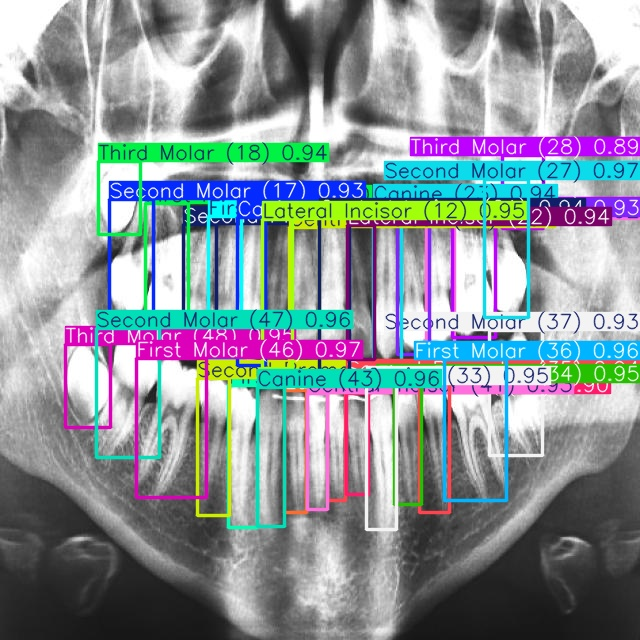

Displaying: runs/detect/predict/cate5-00018_jpg.rf.c1be210fbd78cfab825faf0c792ce7ac.jpg


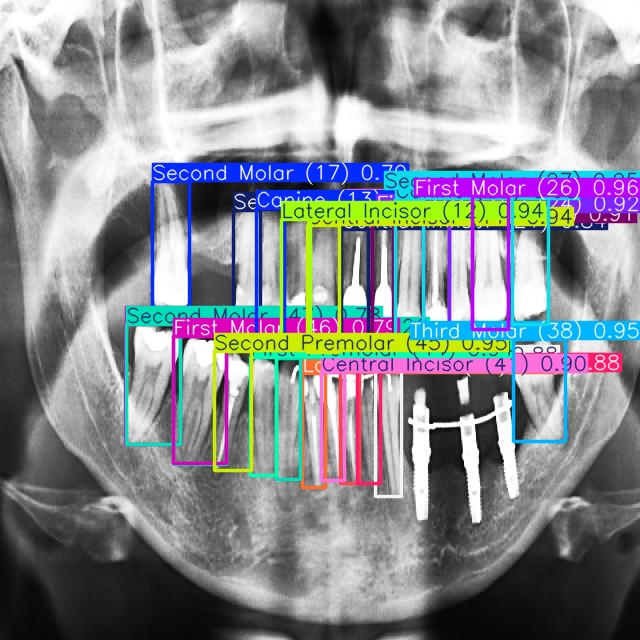

Displaying: runs/detect/predict/b94abb31-20250429-142751426.jpg


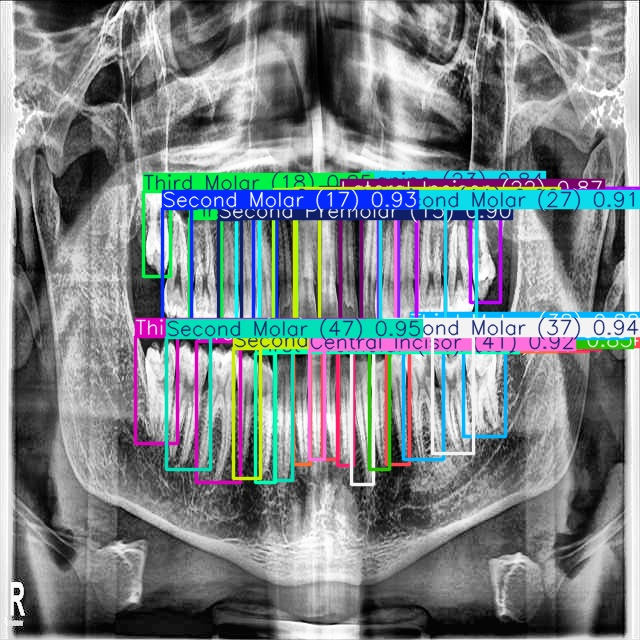

In [27]:
import glob
from IPython.display import display, Image as IPImage

# Get a list of predicted images from the test set
predicted_images_dir = 'runs/detect/predict2' # Or runs/detect/predictX if multiple runs
predicted_images = glob.glob(f'{predicted_images_dir}/*.jpg') # Adjust extension if needed

print(f"Found {len(predicted_images)} predicted images.")

# Display the first few predicted images
num_images_to_display = 3
print(f"Displaying the first {num_images_to_display} images:")

for img_path in predicted_images[:num_images_to_display]:
    print(f"Displaying: {img_path}")
    display(IPImage(filename=img_path))

### Training Curves

In [28]:
from IPython.display import display, Image as IPImage

# Path to the results plot generated during training
results_plot_path = 'runs/dental_fdi_pretrained4/results.png' # Adjust if your run name was different

print(f"Displaying training results plot from: {results_plot_path}")
try:
    display(IPImage(filename=results_plot_path))
except FileNotFoundError:
    print(f"Training results plot not found at {results_plot_path}. Please ensure training completed successfully.")

Displaying training results plot from: runs/dental_fdi_pretrained4/results.png
Training results plot not found at runs/dental_fdi_pretrained4/results.png. Please ensure training completed successfully.


Found 51 predicted images.
Displaying the first 3 images:
Displaying: runs/detect/predict2/cate9-00022_jpg.rf.bed596edcecf1f2b424a5741e3bb6806.jpg


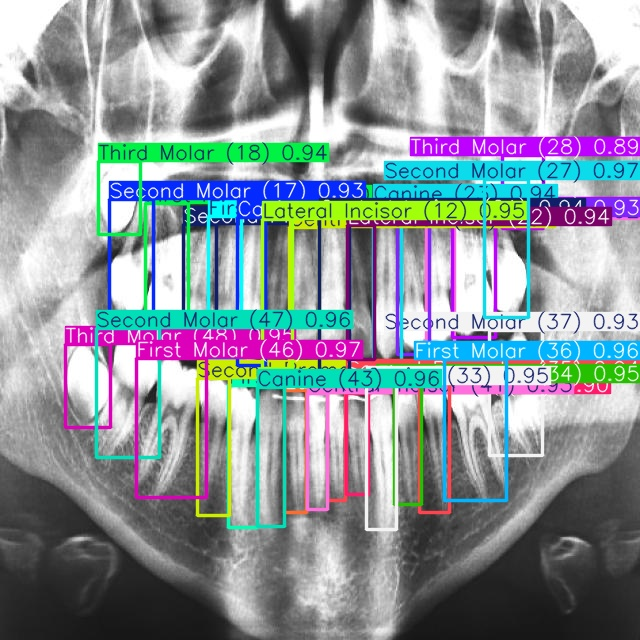

Displaying: runs/detect/predict2/cate5-00018_jpg.rf.c1be210fbd78cfab825faf0c792ce7ac.jpg


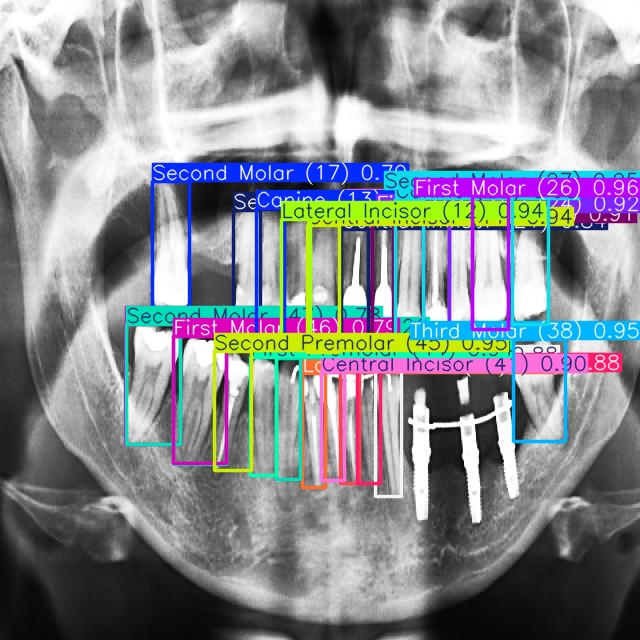

Displaying: runs/detect/predict2/b94abb31-20250429-142751426.jpg


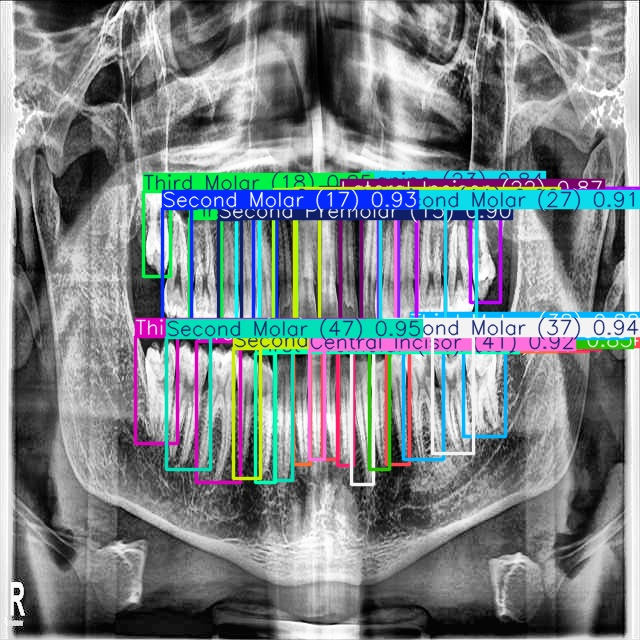

In [29]:
import glob
from IPython.display import display, Image as IPImage

# Get a list of predicted images from the test set
predicted_images_dir = 'runs/detect/predict2' # Or runs/detect/predictX if multiple runs
predicted_images = glob.glob(f'{predicted_images_dir}/*.jpg') # Adjust extension if needed

print(f"Found {len(predicted_images)} predicted images.")

# Display the first few predicted images
num_images_to_display = 3
print(f"Displaying the first {num_images_to_display} images:")

for img_path in predicted_images[:num_images_to_display]:
    print(f"Displaying: {img_path}")
    display(IPImage(filename=img_path))